# Librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
seed = 42

# Lectura

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Bagging with Logistic Regression

Reg Log model

In [4]:
import pickle
reg_log_model = pickle.load(open('../data/modelos/reg_log.pkl', 'rb'))

In [7]:
reg_log_model = reg_log_model.best_estimator_

### Optimizar n_estimators

In [10]:
param_grid = {
    'n_estimators': [x for x in range(0,120,20)]
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_bg_rl = GridSearchCV(BaggingClassifier(
                                    LogisticRegression(random_state=reg_log_model.random_state
                                                                        ,C=reg_log_model.C
                                                                        ,solver = reg_log_model.solver
                                                                        ,penalty= reg_log_model.penalty),
                                    random_state = seed)
                            ,param_grid=param_grid
                            ,scoring='roc_auc'
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_bg_rl.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=BaggingClassifier(estimator=LogisticRegression(C=10,
                                                                      random_state=42,
                                                                      solver='newton-cg'),
                                         random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [0, 20, 40, 60, 80, 100]},
             return_train_score=True, scoring='roc_auc')

In [11]:
print(f'Mejor modelo cuenta con parametros: {grid_search_bg_rl.best_estimator_}')
print(f'El AUC es de: {round(grid_search_bg_rl.best_score_,3)}')

Mejor modelo cuenta con parametros: BaggingClassifier(estimator=LogisticRegression(C=10, random_state=42,
                                               solver='newton-cg'),
                  n_estimators=80, random_state=42)
El AUC es de: 0.852


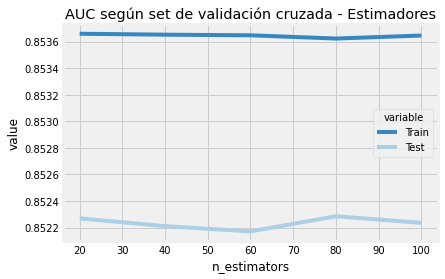

In [14]:
n_estimators_list = [i for i in grid_search_bg_rl.cv_results_['param_n_estimators'].data]


mean_test_score_list = list(grid_search_bg_rl.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_bg_rl.cv_results_['mean_train_score'])

svm_df = pd.DataFrame(list(zip(n_estimators_list,mean_train_score_list, mean_test_score_list)),
                                columns=['n_estimators','mean_train_score', 'mean_test_score'])

df_melt = svm_df.melt(id_vars=['n_estimators'],value_vars= ['mean_train_score','mean_test_score'])
df_melt.variable.replace({'mean_train_score':'Train',
                'mean_test_score':'Test'},inplace=True)

sns.lineplot(data=df_melt, x='n_estimators', y="value", hue="variable", palette ='Blues_r')
plt.title('AUC según set de validación cruzada - Estimadores')

plt.show()

### Optimizar max samples

In [15]:
param_grid = {
    'max_samples': [0.1,0.3,0.5,0.7,0.9]
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_bg_rl_samples = GridSearchCV(BaggingClassifier(
                                    LogisticRegression(random_state=reg_log_model.random_state
                                                                        ,C=reg_log_model.C
                                                                        ,solver = reg_log_model.solver
                                                                        ,penalty= reg_log_model.penalty)
                                    ,random_state = seed
                                    ,n_estimators=80)
                            ,param_grid=param_grid
                            ,scoring='roc_auc'
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_bg_rl_samples.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=BaggingClassifier(estimator=LogisticRegression(C=10,
                                                                      random_state=42,
                                                                      solver='newton-cg'),
                                         n_estimators=80, random_state=42),
             n_jobs=-1, param_grid={'max_samples': [0.1, 0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='roc_auc')

In [16]:
print(f'Mejor modelo cuenta con parametros: {grid_search_bg_rl_samples.best_estimator_}')
print(f'El AUC es de: {round(grid_search_bg_rl_samples.best_score_,3)}')

Mejor modelo cuenta con parametros: BaggingClassifier(estimator=LogisticRegression(C=10, random_state=42,
                                               solver='newton-cg'),
                  max_samples=0.3, n_estimators=80, random_state=42)
El AUC es de: 0.852


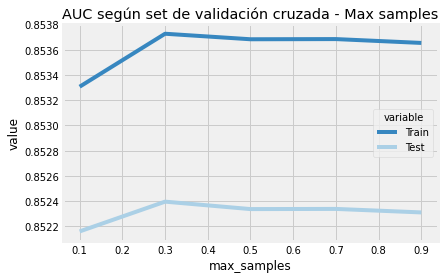

In [18]:
max_samples_list = [i for i in grid_search_bg_rl_samples.cv_results_['param_max_samples'].data]


mean_test_score_list = list(grid_search_bg_rl_samples.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_bg_rl_samples.cv_results_['mean_train_score'])

svm_df = pd.DataFrame(list(zip(max_samples_list,mean_train_score_list, mean_test_score_list)),
                                columns=['max_samples','mean_train_score', 'mean_test_score'])

df_melt = svm_df.melt(id_vars=['max_samples'],value_vars= ['mean_train_score','mean_test_score'])
df_melt.variable.replace({'mean_train_score':'Train',
                'mean_test_score':'Test'},inplace=True)

sns.lineplot(data=df_melt, x='max_samples', y="value", hue="variable", palette ='Blues_r')
plt.title('AUC según set de validación cruzada - Max samples')

plt.show()

# Resultados CV test

In [20]:
results = cross_validate(
    grid_search_bg_rl_samples.best_estimator_,
    X_train,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_bagging_rl = pd.DataFrame(results)

In [22]:
mean_results = pd.DataFrame(results_bagging_rl.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,11.90
score_time,0.03
test_accuracy,0.80
test_precision,0.72
test_recall,0.63
test_f1,0.67
test_roc_auc,0.85


In [23]:
mean_results.to_csv('../data/cv_results/bagging_rl.csv', index=False)

# Resultados test

In [24]:
preds = grid_search_bg_rl_samples.predict(X_test)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       603
           1       0.71      0.55      0.62       297

    accuracy                           0.78       900
   macro avg       0.76      0.72      0.73       900
weighted avg       0.77      0.78      0.77       900

0.7205387205387206


# Guardamos modelo y resultados

In [25]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [26]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [27]:
resultados

,Resultados en test
AUC,0.72
Accuracy,0.78
Recall,0.55
Precision,0.71
F1_score,0.62


In [28]:
resultados.to_csv('../data/resultados/bagging_rl.csv',index=False)

In [29]:
import pickle
pickle.dump(grid_search_bg_rl_samples, open('../data/modelos/bagging_rl.pkl', 'wb'))